In [1]:
# 基本庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Darts - 時間序列相關庫
import darts
from darts import TimeSeries, concatenate
from darts.models import LightGBMModel, Prophet

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics.metrics import mape, mae, mse, ape
from darts.logging import get_logger, raise_log, raise_if_not

# Scikit-learn - 數據預處理
from sklearn.preprocessing import MinMaxScaler
from tools.callbacks import LossLoggingCallback
from tools.calculate_95_ci import calculate_95_ci
from tools.calculate_metrics import calculate_metrics
from tools.data_loader import statistics_load_and_preprocess_data

In [2]:
location = 'Linkou' 
model_type = 'Prophet' 
location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

#Data preprocess

In [3]:
train_series_scaled, test_series_scaled, combined_series_scaled, train_series, test_series, combined_series, ED_covariates, scaler = statistics_load_and_preprocess_data(location)

#Model

In [4]:
model = Prophet(add_seasonalities=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)
model.fit(train_series_scaled)

15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [5]:
forecast_horizon =90      
retrain = True
stride = 90
train_length = location_params[location]['train_end']

# Assuming 'test_series' and 'ED_covariates' are properly defined Darts TimeSeries objects
# Perform the historical forecast
backtest_series = model.historical_forecasts(
    series=combined_series_scaled,
    future_covariates=ED_covariates,
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=retrain,
    start=pd.Timestamp('2018-01-01'),
    train_length = train_length,
    last_points_only=False,
    verbose=True,
)
 

  0%|          | 0/19 [00:00<?, ?it/s]

15:10:36 - cmdstanpy - INFO - Chain [1] start processing
15:10:36 - cmdstanpy - INFO - Chain [1] done processing
15:10:37 - cmdstanpy - INFO - Chain [1] start processing
15:10:38 - cmdstanpy - INFO - Chain [1] done processing
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing
15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:43 - cmdstanpy - INFO - Chain [1] done processing
15:10:44 - cmdstanpy - INFO - Chain [1] start processing
15:10:45 - cmdstanpy - INFO - Chain [1] done processing
15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing
15:10:49 - cmdstanpy - INFO - Chain [1] done processing
15:10:50 - cmdstanpy - INFO - Chain [1] start processing
15:10:50 - cmdstanpy - INFO - Chain [1]

In [6]:
# Check if backtest_series is a list of TimeSeries objects
if isinstance(backtest_series, list):
    forecast_df = pd.DataFrame()
    
    # Iterate over each TimeSeries object and concatenate its DataFrame
    for ts in backtest_series:
        temp_df = ts.pd_dataframe()  # Convert TimeSeries to DataFrame
        forecast_df = pd.concat([forecast_df, temp_df])
    
    # Sort by time index and remove duplicates (keeping the last occurrence)
    forecast_df = forecast_df.sort_index()
    forecast_df = forecast_df[~forecast_df.index.duplicated(keep='last')]
    
    # Convert the DataFrame back to a TimeSeries object
    forecast_series = TimeSeries.from_dataframe(forecast_df)

else:
    forecast_series = backtest_series.pd_dataframe()

In [7]:
Model_prediction_df = forecast_series.pd_dataframe()
Model_prediction_df = Model_prediction_df.loc['2018-01-01':]

# Assuming 'scaler' is previously defined and fitted
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                                           index=Model_prediction_df.index,
                                           columns=Model_prediction_df.columns)
Model_prediction_df_inverse.index.name = 'Date'
Model_prediction_df_inverse.columns = ['No']

# Convert the inverse-transformed DataFrame back to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)

#Calculate error and visualization

In [8]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)
MAE = mae(combined_series, Model_prediction_ts_inverse)
APE= ape(combined_series, Model_prediction_ts_inverse)

APEdf = pd.DataFrame(APE, columns=['APE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index

In [9]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

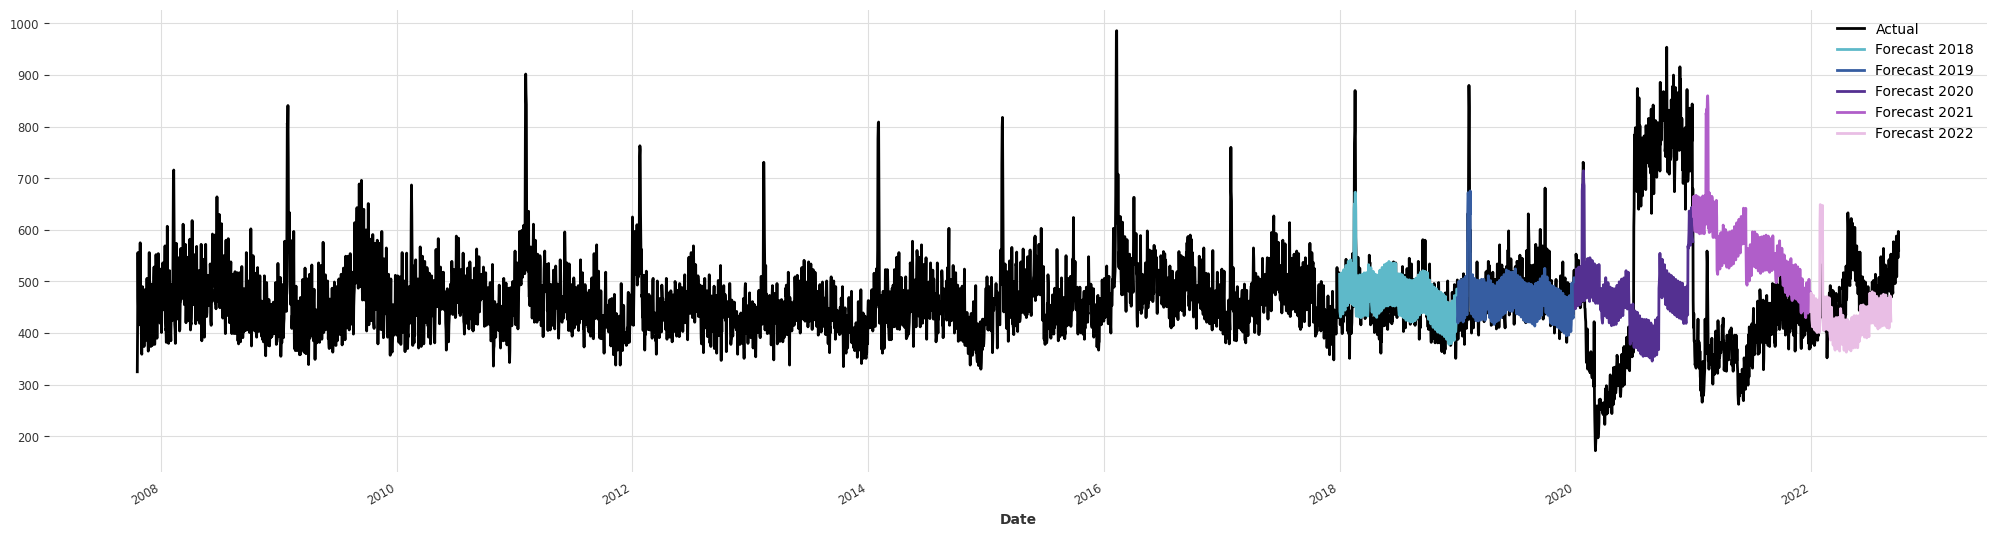

In [10]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
combined_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

#Save prediction

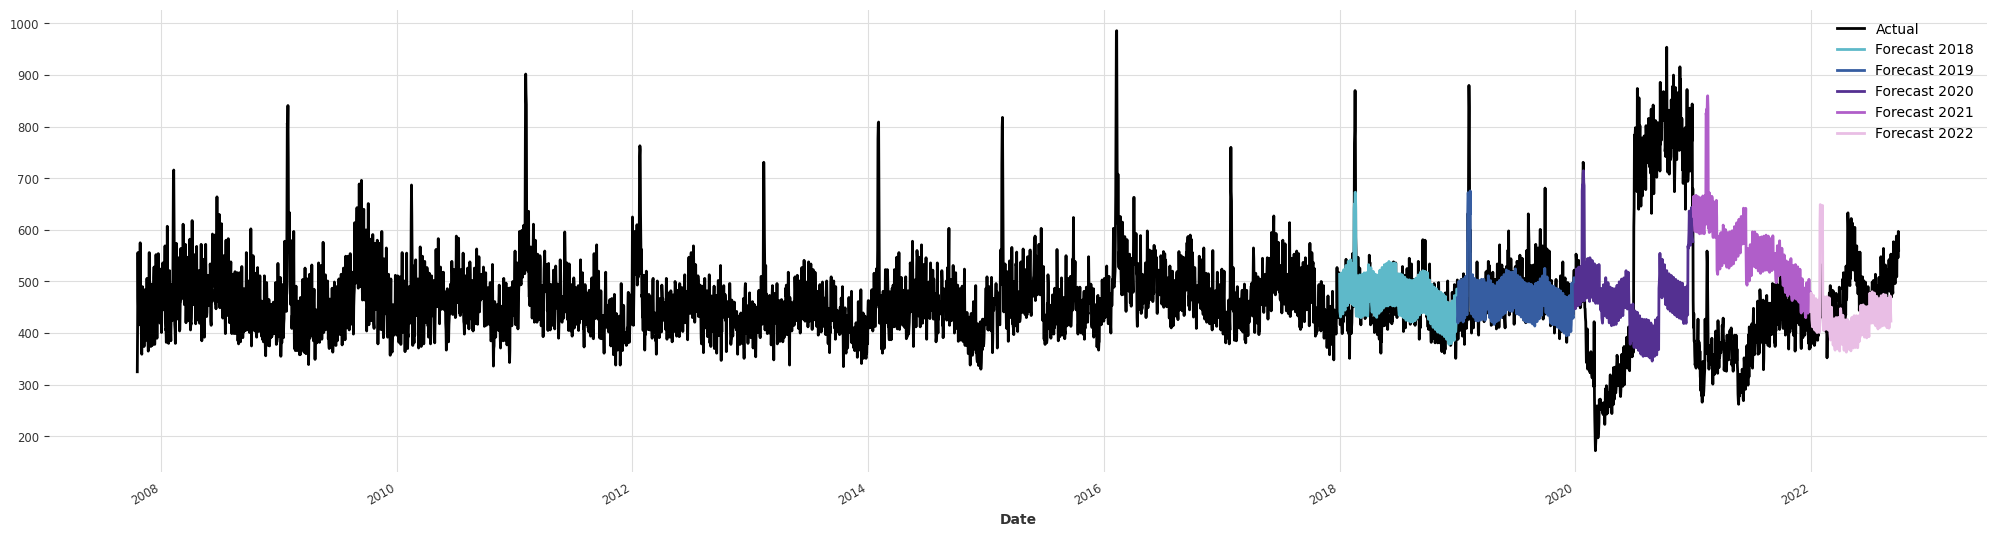

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Prophet\Linkou\Linkou_Prophet_FH90_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Prophet\Linkou\Linkou_Prophet_FH90_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Prophet\Linkou\Linkou_Prophet_FH90.csv


In [11]:
forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
combined_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(combined_series, yearly_dataarrays, APEdf, calculate_95_ci)

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'APE 95% CI':<20}\n")
        f.write("-" * 65 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            if isinstance(metric['APE 95% CI'], tuple):
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})\n")
            else:
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"APE 95% CI: N/A\n")
                
    print(f"Metrics saved to {metrics_txt_path}")
else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
Model_prediction_df_inverse.to_csv(csv_filepath, index=True)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")